# Feature Extraction per batch of T sec

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.cluster import DBSCAN,KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection
from pickle import dump
import time

## Analyze each 10s batch
- every 10 s a batch of flows is read
- convert each batch into pandas df for feature extraction

### Definitions:
- entry is each line in csv (packet from netflow)
- conns is unique (src_ip, dst_ip)
- flow is unique flow tuple (src_ip, src_port, dst_ip, dst_port, ip_protocol)
- src_port is randomly assigned
- change in distribution of dst_port may indicate port scanning
- change in distribution of src_ip or dst_ip may indicate DoS

In [4]:

flow_fields = [
    "src_ip",
    "src_port",
    "dst_ip",
    "dst_port",
    "ip_protocol",
    "l7_proto",
    "in_bytes",
    "out_bytes",
    "in_pkts",
    "out_pkts",
    "tcp_flags",
    "duration",
    "label",
    "anomaly"
]

with open("datasets/NF-CSE-CIC-IDS2018.csv", "r") as csvfile:
    # pass input data stream as open("data.csv", "r") to csv.reader for testing
    # read and process line by line don't read into list
    df_src = pd.read_csv(csvfile, names=flow_fields)

In [5]:
#df.loc[df.label ==0, 'label'] = -1

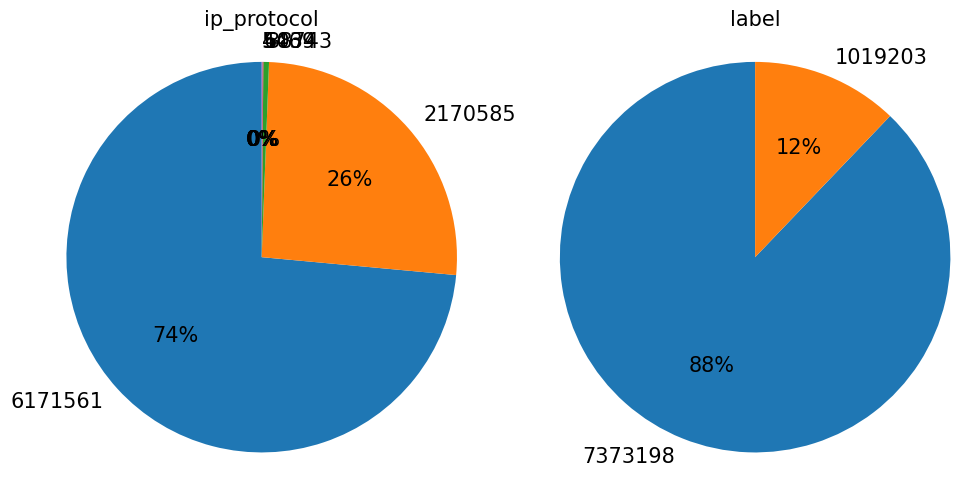

In [6]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
    for ax, col in zip(axes.ravel(), cols_list):
        counts = df[col].value_counts()
        ax.pie(counts, labels=counts, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 15})
        ax.set_title(col, fontsize=15)
        ax.axis('equal')
    plt.tight_layout()
    plt.show()

pie_plot(df_src, ['ip_protocol', 'label'], 1, 2)

In [14]:
def do_scl(df_num, cols):
    print("Original values:\n", df_num)

    scaler = RobustScaler()
    scaler_temp = scaler.fit_transform(df_num)

    with open("IsolationForestModel_scaler_test.pkl", "wb") as f:
        dump(scaler, f, protocol=5)
    
    std_df = pd.DataFrame(scaler_temp, columns =cols)

    print("\nScaled values:\n", std_df)

    return std_df

cat_cols = ['ip_protocol']

In [15]:
def process(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = do_scl(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    print("Before encoding:")
    print(dataframe['ip_protocol'])

    dataframe = pd.get_dummies(dataframe, columns = ['ip_protocol'])

    print("\nColumns after encoding:")
    print(dataframe.filter(regex='^protocol_type_'))
    
    return dataframe

In [16]:
df = df_src.drop(['src_ip', 'dst_ip','l7_proto','anomaly'] ,axis=1)
scaled_train = process(df)

Original values:
          src_port  dst_port  in_bytes  out_bytes  in_pkts  out_pkts  \
0           51128       443       152          0        3         0   
1             443     51036       994        979        7         7   
2           12262       445       585        344        5         4   
3           61023        53       136        168        2         2   
4             443     51037        72         40        1         1   
...           ...       ...       ...        ...      ...       ...   
8392396        22     40810      2601          0       12         0   
8392397     15476        23        44          0        1         0   
8392398        23     15476        40          0        1         0   
8392399     56407        53        72          0        1         0   
8392400        53     56407       126          0        1         0   

         tcp_flags  duration  label  
0              194   4285680      0  
1               24   4234714      0  
2              

In [17]:
y = scaled_train['label'].values
y = y.astype('int')

X = scaled_train.drop(['label'], axis=1)

x_train, x_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = \
    train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
kernal_evals = dict()

In [10]:
def evaluation(model, name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    execution_time = end_time - start_time
    print("Time " + str(name) + " : %.3f sec" % execution_time)

    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))

    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))

    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precision " + str(name) + " {}  Test Precision ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay( \
        confusion_matrix =                       \
        confusion_matrix,                        \
        display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    ax.set_title(name, fontsize=15)
    cm_display.plot(ax=ax)
    plt.show()

In [11]:
def evaluation_if(model, name, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    execution_time = end_time - start_time
    print("Time " + str(name) + " : %.3f sec" % execution_time)

    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    kernal_evals[str(name)] = [train_accuracy, test_accuracy]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
   
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay( \
        confusion_matrix =                       \
        confusion_matrix,                        \
        display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    ax.set_title(name, fontsize=15)
    cm_display.plot(ax=ax)
    plt.show()

In [12]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=500, random_state=42)
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Time XGBoost : 3.618 sec
Training Accuracy XGBoost 99.33347433392117  Test Accuracy XGBoost 99.33273001005075
Training Precision XGBoost 99.92184654705602  Test Precision XGBoost 99.89188797732234
Training Recall XGBoost 94.5838746759612  Test Recall XGBoost 94.61489465948064


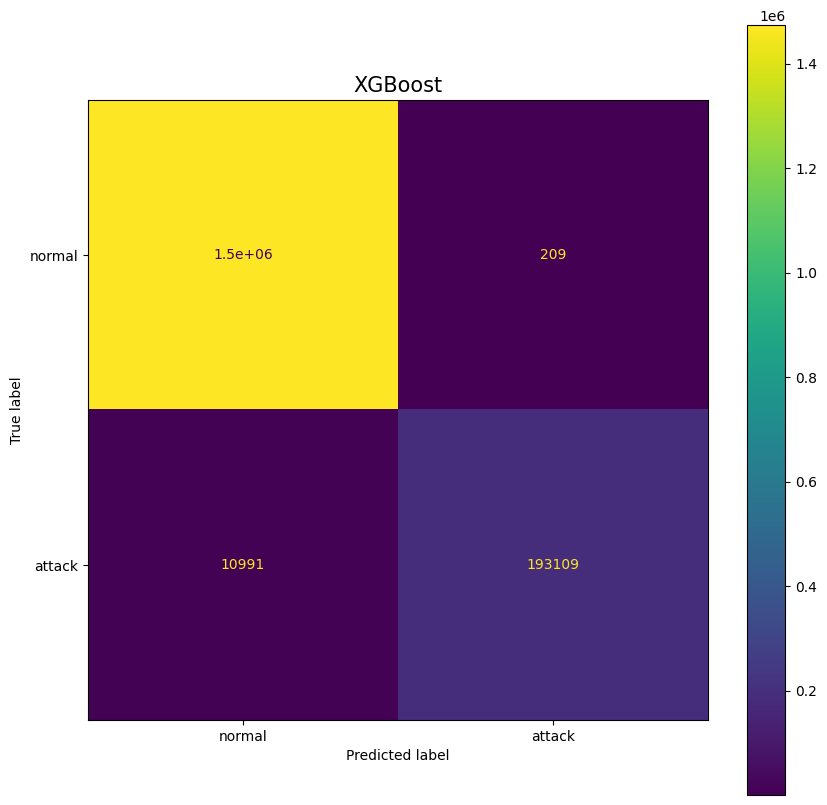

In [13]:
evaluation(xgb_classifier, "XGBoost", x_train, x_test, y_train, y_test)

In [14]:
rf = RandomForestClassifier().fit(x_train, y_train)
evaluation(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

KeyboardInterrupt: 

In [ ]:
#clf = IsolationForest(random_state=47,n_jobs=-1, contamination=0.05,n_estimators=1000) #Work 84.3%
clf = IsolationForest(random_state=47,n_jobs=-1, contamination=0.01,n_estimators=1000)
clf.fit(x_train)

In [ ]:
predict_test = clf.predict(x_test)

In [ ]:
predict_train = clf.predict(x_train)

In [ ]:
predict_test[predict_test == 1] = 0
predict_train[predict_train == 1] = 0

predict_test[predict_test == -1] = 1
predict_train[predict_train == -1] = 1

In [ ]:
test_accuracy = metrics.accuracy_score(y_test,predict_test)
train_accuracy = metrics.accuracy_score(y_train,predict_train)

In [ ]:
train_accuracy,test_accuracy

In [ ]:
n_error_test = predict_test[predict_test == 1].size
n_error_outliers = predict_train[predict_train == 1].size

In [ ]:
print( "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers))

In [ ]:
print("Training Accuracy " + "IsolationForestClassifier" + " {}  Test Accuracy ".format(train_accuracy*100) + 'IsolationForestClassifier' + " {}".format(test_accuracy*100))

In [ ]:
metrics.confusion_matrix(y_test, predict_test)

In [ ]:
clf.score_samples(X)

In [ ]:
plt.scatter(x_train.values[:, 0], x_train.values[:, 1], c=predict_train, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
with open("IsolationForestModel_test.pkl", "wb") as f:
    dump(clf, f, protocol=5)

In [18]:
# Here you can replace pickle with joblib or cloudpickle
from pickle import load
with open("IsolationForestModel_86.pkl", "rb") as f:
    clf_test = load(f)

In [19]:
predict_test_data= clf_test.predict(x_test)

In [ ]:
predict_test_data[predict_test_data == 1] = 0
predict_test_data[predict_test_data == -1] = 1

In [ ]:
test_accuracy_test = metrics.accuracy_score(y_test,predict_test_data)
test_accuracy_test

In [ ]:
clt_km = KMeans(n_clusters=7, random_state=170)

In [ ]:
pred_y = clt_km.fit_predict(X)

In [ ]:
plt.scatter(X.values[:,0], X.values[:,1],c=pred_y)
plt.suptitle("Unexpected KMeans clusters").set_y(0.95)
plt.scatter(clt_km.cluster_centers_[:, 0], clt_km.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [ ]:
df['predict_dbscan'] = pred_y

In [ ]:
df_outliers =  df[ df['clusters']==0]

In [ ]:
df_outliers

In [ ]:
dbscan = DBSCAN(n_jobs=-1)
clusters = dbscan.fit_predict(X)

In [ ]:
plt.scatter(X.values[:, 0], X.values[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
df['predict_dbscan'] = clusters

In [ ]:
df_outliers =  df[ df['predict_dbscan']!=0 ]

In [ ]:
df_outliers.count()